### Introduction

This notebook is made for a basic introduction on how to analyze data obtained through [Netra's](http://netra.io) API. In this notebook, we will analyze data obtained using images that Northeastern Students took.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import time
import matplotlib.pyplot as plt

In [2]:
def mkdir(d):
    if not os.path.isdir(d):
        os.mkdir(d)

### CSV Anonamization

Making sure to keep people's information as anonymous as possible is very important. I've already anonamized the user ids, but now let's make sure to anonamize the urls as well.

In [3]:
url_csv = pd.read_csv('inputs/mini_dataset.csv')
url_csv.head()

,user,url
0,2,https://instagram.fbed1-2.fna.fbcdn.net/vp/465...
1,10,https://instagram.fbed1-2.fna.fbcdn.net/vp/a4b...
2,88,https://instagram.fbed1-2.fna.fbcdn.net/vp/e9a...
3,74,https://instagram.fbed1-2.fna.fbcdn.net/vp/f2f...
4,98,https://instagram.fbed1-2.fna.fbcdn.net/vp/370...


As you can see, the users are anonamized, but the urls are not. The following step is only necessary as I used this code for anonamizing the users as well, so feel free to ignore.

In [4]:
unique_users = set(url_csv.user)
user_ids = {user: user for ind, user in enumerate(unique_users)}
# user_ids

Now let's get all the unique urls, and create an id for each.

In [5]:
unique_urls = set(url_csv.url)
url_ids = {url: ind for ind, url in enumerate(unique_urls)}
# url_ids

Finally, we map the urls to the new ids.

In [6]:
url_csv.user = url_csv.user.map(user_ids)
url_csv.url = url_csv.url.map(url_ids)
url_csv.head()

,user,url
0,2,5
1,10,72
2,88,99
3,74,173
4,98,76


Presto! Let's write this to a csv.

In [7]:
mkdir('outputs')
url_csv.to_csv("outputs/urls_mini_anonamized.csv", index=False)

And now, we will create a map from the urls to the users, which will be useful in the future when parsing the json data.

In [8]:
url_to_user = {row[1]['url']: row[1]['user'] for row in url_csv.iterrows()}

### Loading Brands Data

In [9]:
with open('inputs/brands.json' , 'r') as brand_file:
    #Load each result as a line, remove comma at end as that was a bad idea :)
    results = [line[:-1] for line in brand_file.read().strip().split('\n')]

In [10]:
json.loads(results[5])

{'brands': [],
 'errors': [],
 'image_url': 'https://instagram.fbed1-2.fna.fbcdn.net/vp/7aa77686b64dbdbbe5afba69969a81af/5B433EEE/t51.2885-15/e35/13248719_586384048191731_1983118973_n.jpg',
 'metadata': '',
 'request_id': 'jas58r9iqsjfbejt03'}

We how have a list of json string representing a brand result for each image. We want to put this into a dataframe so that we can easily analyze the results. We will now process each JSON string.

In [11]:
brands = []
for result in results:
    try:
        result = json.loads(result)
        for brand in result['brands']:
            brands.append({'brand': brand['label'], 'category': brand['brand_category_name'], 'user': url_to_user[url_ids[result['image_url']]], 'confidence': brand['confidence']})
    except Exception as e:
        print(e)
        
brands_results = pd.DataFrame(brands)
brands_results.head(20)

,brand,category,confidence,user
0,New Balance,Fitness Apparel,100,74
1,New Balance,Fitness Apparel,91,74
2,Toyota,Automobiles,100,89
3,Bud Light,Alcoholic Beverages,99,96
4,Bud Light,Alcoholic Beverages,98,96
5,Bud Light,Alcoholic Beverages,96,96
6,Kate Spade,Clothing,100,31
7,Boston Celtics,Sports League,100,42
8,Boston Bruins,Sports League,99,61
9,Neutrogena,Cosmetics,94,64


Finally, let's write this result to a csv for safekeeping.

In [12]:
brands_results.to_csv("outputs/brands_mini.csv", index=False)

### Loading Humans Data

In [13]:
with open('inputs/humans.json' , 'r') as human_file:
    #Load each result as a line, remove comma at end as that was a bad idea :)
    humans_json = [line[:-1] for line in human_file.read().strip().split('\n')]

In [14]:
json.loads(humans_json[11])
len(humans_json)

200

We now have the humans data in json form as well. Again, we will process it so that it is in a data frame.

In [15]:
humans = []
for result in humans_json:
    try:
        result = json.loads(result)
        for human in result['humans']:
#             print(brand)
            human['url'] = url_ids[result['image_url']]
            human['user'] = url_to_user[human['url']]
            
            humans.append(human)
#             brands_results.append({'brand': brand[]})
    except Exception as e:
        print(e)
        
humans_results = pd.DataFrame(humans)
humans_results.head(20)

,age,ethnicity,ethnicity_confidence,gender,gender_confidence,human_confidence,tag_location,url,user
0,20-29,white,99,female,93,93,"[2, 2, 30, 30]",5,2
1,20-29,white,99,female,97,76,"[74, 51, 7, 5]",168,92
2,30-39,white,80,female,99,97,"[43, 15, 12, 12]",115,81
3,30-39,white,96,female,99,99,"[47, 29, 31, 24]",189,29
4,20-29,asian,84,female,99,99,"[57, 23, 10, 10]",98,1
5,20-29,white,95,female,87,97,"[22, 23, 10, 10]",98,1
6,0-12,white,70,female,93,95,"[20, 43, 8, 8]",122,70
7,30-39,white,81,female,99,91,"[35, 30, 10, 8]",40,2
8,20-29,black or african american,39,male,99,99,"[35, 65, 8, 8]",137,83
9,20-29,asian,43,female,99,99,"[36, 9, 37, 29]",88,43


And again, let's write this to a csv.

In [16]:
humans_results.to_csv("outputs/humans_mini.csv", index=False)

Only one more left!

### Loading Context Data

In [17]:
with open('inputs/context.json' , 'r') as context_file:
    #Load each result as a line, remove comma at end as that was a bad idea :)
    context_json = [line[:-1] for line in context_file.read().strip().split('\n')]

In [18]:
json.loads(context_json[54])
len(context_json)

200

Looks good again! The only issue, is that we want to use the context hierarchy. So, we will have to process the data a little differently this time.

In [19]:
def deep_in(d, val):
    if val in d:
        return True
    elif type(d) in [dict]:
        return True in [deep_in(v, val) for v in d.values() if type(v) in [list, dict]] + [v == val for v in d.values() if type(v) not in [list, dict]]
    else:
        return False

`deep_in` is a helper function to determine if a context label is within a hierarchy chain. Now we will use this to ge the second level of the hierarchy for a label.

In [20]:
def get_second_level(label, harchy):
    for k in harchy:
        if deep_in(harchy[k], label):
            return list(harchy[k].keys())[0]

Now we can process the data as normal.

In [21]:
contexts = []
for i, result in enumerate(context_json):
    try:
        result = json.loads(result)
        for context in result['context']:
            second_level = get_second_level(context['label'], result['context_hierarchy'])
            contexts.append({'confidence': context['confidence'], 'label': context['label'], 'second_level': second_level, 'url': url_ids[result['image_url']], 'user': url_to_user[url_ids[result['image_url']]]})
#             brands_results.append({'brand': brand[]})
    except Exception as e:
        print(e)
contexts_results = pd.DataFrame(contexts)
display(contexts_results.head(20))
contexts_results.to_csv('outputs/test_contexts.csv')

,confidence,label,second_level,url,user
0,88,glasses,Fashion Accessories,5,2
1,80,beauty,Fashion Accessories,5,2
2,56,smile,People,5,2
3,54,photography,Art,5,2
4,52,girl,People,5,2
5,50,vision care,Fashion Accessories,5,2
6,92,horizon,Sky,99,88
7,86,sea,Body of Water,99,88
8,81,shore,Body of Water,99,88
9,77,morning,Time of Day,99,88


And for the final time, write this result to a csv.

In [22]:
contexts_results.to_csv("outputs/contexts_mini.csv", index=False)

### Analyzing the Data

Now let's load in the full data set, which is anonamized.

In [23]:
url_csv = pd.read_csv('inputs/urls_anonamized.csv')
print('Urls:')
display(url_csv.head())
url_to_user = {row[1]['url']: row[1]['user'] for row in url_csv.iterrows()}
brands_results = pd.read_csv('inputs/brands_full.csv')
print('Brands:')
display(brands_results.head())
contexts_results = pd.read_csv('inputs/contexts_full.csv')
print('Contexts:')
display(contexts_results.head())
print('Humans:')
humans_results = pd.read_csv('inputs/humans_full.csv')
display(humans_results.head())

Urls:


,user,url
0,79,8781
1,79,13613
2,79,8231
3,79,11487
4,79,13493


Brands:


,brand,category,confidence,user
0,Boston Red Sox,Sports League,100,79
1,Domaine Chandon California,Alcoholic Beverages,98,79
2,Boston Red Sox,Sports League,96,79
3,Dunkin' Donuts,Coffee,100,79
4,Toronto Blue Jays,Sports League,100,12


Contexts:


,confidence,label,second_level,url,user
0,90,photograph,Art,8781,79
1,60,bride,Family & Relationships,8781,79
2,44,dress,Fashion Accessories,8781,79
3,40,ceremony,Family & Relationships,8781,79
4,33,woman,Family & Relationships,8781,79


Humans:


,age,ethnicity,ethnicity_confidence,gender,gender_confidence,human_confidence,tag_location,url,user
0,30-39,white,54,female,99,99,"[46, 13, 7, 7]",13493,79
1,30-39,white,74,female,99,99,"[16, 16, 10, 10]",13493,79
2,30-39,white,65,female,98,99,"[60, 13, 7, 7]",13493,79
3,40-49,white,87,female,99,99,"[76, 15, 8, 8]",13493,79
4,30-39,white,82,female,98,61,"[47, 17, 6, 6]",13613,79


In [24]:
brands_results.brand.value_counts()[0:20]

Northeastern University    68
Nike                       44
Adidas                     30
Coca Cola                  24
The North Face             20
New Balance                14
Ford                       14
Gillette                   12
New England Patriots       10
Boston Red Sox             10
Bud Light                   9
Bank of America             9
Garmin                      9
Ralph Lauren                9
Under Armour                9
Starbucks                   8
Dunkin' Donuts              8
Reebok                      8
Boston Bruins               7
Bose                        7
Name: brand, dtype: int64

Unsurprisingly, Northeastern is at the top, but there are some other notable brands. The Red Sox and Patriots are local teams, so it's nice to see them among the sample. And considering the popularity of dunks among New Englanders, it's unsurprising to see it. Next let's do the same for brand categories.

In [25]:
brands_results.category.value_counts()[0:20]

Fitness Apparel          114
Sports League             88
Alcoholic Beverages       71
Education                 68
Consumer Electronics      41
Automobiles               38
Soda                      35
Sports and Outdoors       28
Clothing                  22
Financial Services        20
Coffee                    18
Candy                     15
Personal Care             14
Media (communication)     13
Fast Food                 12
Superhero                 10
Social Network             9
Telecommunication          8
Condiments                 6
Luxury Goods               6
Name: category, dtype: int64

Based on this, we can likely conclude that Northeastern students are pretty sporty. Also, like most colleges, we like to drink. Now let's get user counts for brands.

In [26]:
brands_results.head()
user_brands = {user: set() for user in brands_results.user.unique()}
for row in brands_results.iterrows():
    user_brands[row[1]['user']].add(row[1]['brand'])

brand_totals = {brand: 0 for brand in brands_results.brand.unique()}
for user in user_brands:
    for brand in user_brands[user]:
        brand_totals[brand] += 1
brand_out = pd.DataFrame([{'Brand': item[0], 'Count': item[1]} for item in brand_totals.items()])
brand_out.sort_values(by=['Count'], ascending=False)[0:20]


,Brand,Count
8,Northeastern University,34
9,Nike,19
10,Adidas,17
12,Coca Cola,16
27,The North Face,13
7,Ford,12
28,Starbucks,8
0,Boston Red Sox,8
4,New England Patriots,8
2,Dunkin' Donuts,8


One of the most interesting things to note here is that though there were only 8 pictures of Dunkin Donuts total they were on 8 different accounts. Meanwhile, Nike had 44 total photos, but only 19 total users. This could mean huskies are more passionate about Nike, or that they are just more likely to post about it. Now let's do the same analysis for brand category.

In [27]:
user_brand_categories = {user: set() for user in brands_results.user.unique()}
for row in brands_results.iterrows():
    user_brand_categories[row[1]['user']].add(row[1]['category'])

brand_category_totals = {brand_category: 0 for brand_category in brands_results.category.unique()}
for user in user_brand_categories:
    for brand_category in user_brand_categories[user]:
        brand_category_totals[brand_category] += 1
category_out = pd.DataFrame([{'Brand_Category': item[0], 'Count': item[1]} for item in brand_category_totals.items()])
category_out.sort_values(by=['Count'], ascending=False)[0:20]


,Brand_Category,Count
0,Sports League,43
1,Alcoholic Beverages,37
7,Fitness Apparel,35
6,Education,34
5,Automobiles,28
10,Consumer Electronics,24
13,Sports and Outdoors,21
8,Soda,20
2,Coffee,17
22,Clothing,14


These are interesting, but unsurprising results. All of the top brand categories make sense for college students, with a few exceptions that are more unique to huskies. Now let's check out the context of the images that are posted.

In [28]:
contexts_results.head(10)

,confidence,label,second_level,url,user
0,90,photograph,Art,8781,79
1,60,bride,Family & Relationships,8781,79
2,44,dress,Fashion Accessories,8781,79
3,40,ceremony,Family & Relationships,8781,79
4,33,woman,Family & Relationships,8781,79
5,25,wedding,Family & Relationships,8781,79
6,83,soil,Landscaping,11324,79
7,59,agriculture,Agriculture,11324,79
8,25,rural area,Real Estate,11324,79
9,24,field,Agriculture,11324,79


Let's look at the most common tags. Of course, this won't necessarily be the most accurate representation of context, as the same types of tags can appear multiple times per image, but it will give us a general idea.

In [29]:
contexts_results.label.value_counts()[0:20]

people          2758
person          2231
image           1253
art             1184
photograph      1121
clothing         998
sea              940
food             901
meal             865
vacation         783
social group     733
brand            720
sports           703
tree             700
photography      688
vehicle          662
color            658
city             637
team             602
crowd            561
Name: label, dtype: int64

In [30]:
contexts_results.second_level.value_counts()[0:20]

People                        8805
Art                           5795
Food                          4761
Family & Relationships        4622
Color                         4373
Cities, Towns, & Buildings    3893
Body of Water                 2825
Sports                        2822
Live Events                   2797
Terrain                       2675
Wild Animals                  2429
Fashion Accessories           2122
Time of Day                   2006
Flowers, Plants, Trees        1973
Clothing                      1764
Roads and Bridges             1666
Weather                       1534
Travel                        1492
Outdoor Recreation            1358
Nonbuilding Structures        1232
Name: second_level, dtype: int64

It seems that huskies are pretty typical instagrammers. They take selfies, food pictures, and art pictures. Let's collapse these 2nd level tags so that multiple in the same photo don't skew results.

In [31]:
url_to_2ndlvl = {url: set() for url in contexts_results.url.unique()}
for row in contexts_results.iterrows():
    url_to_2ndlvl[row[1]['url']].add(row[1]['second_level'])

second_lvl_to_count = {second_level: 0 for second_level in contexts_results.second_level.unique()} 
for k in url_to_2ndlvl:
    for val in url_to_2ndlvl[k]:
        second_lvl_to_count[val] += 1
second_level_out = pd.DataFrame([{'Second Level': item[0], 'Count': item[1]} for item in second_lvl_to_count.items()])
second_level_out.sort_values(by=['Count'], ascending=False)[0:20]


,Count,Second Level
9,4383,People
0,3223,Art
28,1770,Color
21,1443,"Cities, Towns, & Buildings"
1,1210,Family & Relationships
18,1209,Food
14,1203,Sports
20,1100,Nonbuilding Structures
12,1095,Travel
6,1065,Live Events


The context tags tell us a slightly different story about huskies than the brands results. Though they do plenty of outdoor activities (Body of Water, Terrain, Flowers, Plants, Trees), the primary focus of their instagram profiles is people. Let's do the same analysis, but filter out any context results of confidence < 40.

In [32]:
contexts_results_hc = contexts_results[contexts_results.confidence >= 40]
url_to_2ndlvl = {url: set() for url in contexts_results_hc.url.unique()}
for row in contexts_results_hc.iterrows():
    url_to_2ndlvl[row[1]['url']].add(row[1]['second_level'])

second_lvl_to_count = {second_level: 0 for second_level in contexts_results_hc.second_level.unique()} 
for k in url_to_2ndlvl:
    for val in url_to_2ndlvl[k]:
        second_lvl_to_count[val] += 1
second_level_out = pd.DataFrame([{'Second Level': item[0], 'Count': item[1]} for item in second_lvl_to_count.items()])
second_level_out.sort_values(by=['Count'], ascending=False)[0:20]

,Count,Second Level
10,2787,People
0,1847,Art
24,1249,Color
17,1134,"Cities, Towns, & Buildings"
1,1004,Family & Relationships
14,909,Food
18,825,Body of Water
7,790,Terrain
16,763,Nonbuilding Structures
19,758,Time of Day


Most of the top results stay the same, but Sports really takes a hit. The Art tag is likely due to a sample bias, as the photos are all from instagram. Now, as people were the top context tag, let's get some more information about what types of people huskies are putting on their social media.

Generally, the ethnicity results are not considered very accurate at the moment, so we will be ignoring those.

In [33]:
humans_results.head(10)

,age,ethnicity,ethnicity_confidence,gender,gender_confidence,human_confidence,tag_location,url,user
0,30-39,white,54,female,99,99,"[46, 13, 7, 7]",13493,79
1,30-39,white,74,female,99,99,"[16, 16, 10, 10]",13493,79
2,30-39,white,65,female,98,99,"[60, 13, 7, 7]",13493,79
3,40-49,white,87,female,99,99,"[76, 15, 8, 8]",13493,79
4,30-39,white,82,female,98,61,"[47, 17, 6, 6]",13613,79
5,30-39,white,93,male,99,93,"[39, 8, 8, 8]",8231,79
6,40-49,white,90,male,93,88,"[92, 11, 6, 6]",8231,79
7,20-29,white,90,female,80,99,"[24, 24, 15, 15]",3661,79
8,30-39,white,99,female,99,98,"[55, 27, 14, 14]",3661,79
9,30-39,white,90,female,96,99,"[41, 15, 8, 8]",2929,79


Let's start by getting an idea of the male/female split in the instagram photos.

In [34]:
print('Female split: {}%'.format(round(sum(humans_results.gender == 'female') / len(humans_results.gender) * 100, 2)))
print('Male split: {}%'.format(round(sum(humans_results.gender == 'male') / len(humans_results.gender) * 100, 2)))

Female split: 67.94%
Male split: 32.06%


Interestingly, there are much more pictures of women in the image set than men. This could be due to a bias in the training set, or that huskies post more pictures of women. According to [US News](https://www.usnews.com/best-colleges/northeastern-university-2199), Northeastern's total distribution is 51% women. So, maybe this means women post more pictures of themselves. It would be revealing to compare this distribution to instagram photos in general.

Let's try determining the gender split of the image set by counting the number of images of each gender per user. If there are more images of female than male, we will classify a user as female, and vice versa. For this, we will only consider gender confidence >= 80%.

In [35]:
humans_results_hgc = humans_results[humans_results.gender_confidence >= 80]
user_to_mf_count = {user: [0,0] for user in humans_results_hgc.user.unique()}
for row in humans_results_hgc.iterrows():
    user_to_mf_count[row[1]['user']][row[1]['gender'] == 'female'] += 1

is_female_list = [count[1] > count[0] for count in user_to_mf_count.values()]
sum(is_female_list)
print('Female split: {}%'.format(round(sum(is_female_list) / len(is_female_list) * 100, 2)))
print('Male split: {}%'.format(round((1 - (sum(is_female_list) / len(is_female_list))) * 100, 2)))

Female split: 68.75%
Male split: 31.25%


Though this method is definitely not perfect, it shows that the most likely reason for the gender discrepancy was the distribution of the dataset. This means previous information should be taken with this context, including the brand and context information. Now le'ts check out the ages.

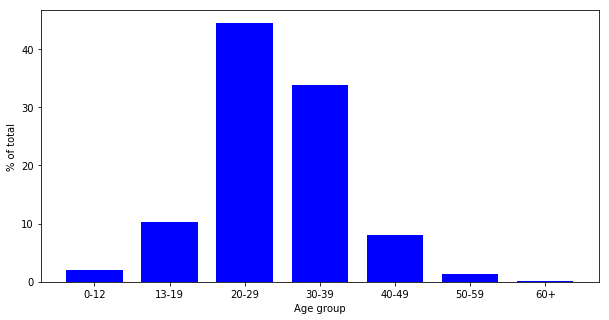

In [36]:
ages = humans_results.age
X = ages.unique()
Y = [sum(ages ==age)/len(ages) * 100 for age in X]
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(X, Y, width=0.75, color="blue")
plt.ylabel('% of total')
plt.xlabel('Age group')
plt.show()

This is about the age distribution we would expect, especially on social media. The likely reason for the 30-39 year old predictions is due to the dataset including alumni.

### Conclusions

Huskies are an outdoorsy group of people. They are passionate about the local sports teams, and about the popular beers in the area. Further, huskies love the people in their life.

##### Contact

Oliver Spohngellert
spohngellert.o@husky.neu.edu